<a href="https://colab.research.google.com/github/nhwhite212/DealingwithDataSpring2021/blob/master/6-Pandas/E-Citibike_Mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Plotting Real-time Data from Citibike

We will now use the Citibike API in combination with Pandas, in order to create a real-time view of the Citibike stations in New York.

The API call at http://www.citibikenyc.com/stations/json gives us a real-time view of the Citibike stations in New York.

In [1]:
# Plotting setup

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 20)
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])

In [2]:
import requests
url = 'http://www.citibikenyc.com/stations/json'
data = requests.get(url).json()
data

{'executionTime': '2016-01-22 04:32:49 PM',
 'stationBeanList': [{'altitude': '',
   'availableBikes': 7,
   'availableDocks': 32,
   'city': '',
   'id': 72,
   'landMark': '',
   'lastCommunicationTime': '2016-01-22 04:30:15 PM',
   'latitude': 40.76727216,
   'location': '',
   'longitude': -73.99392888,
   'postalCode': '',
   'stAddress1': 'W 52 St & 11 Ave',
   'stAddress2': '',
   'stationName': 'W 52 St & 11 Ave',
   'statusKey': 1,
   'statusValue': 'In Service',
   'testStation': False,
   'totalDocks': 39},
  {'altitude': '',
   'availableBikes': 33,
   'availableDocks': 0,
   'city': '',
   'id': 79,
   'landMark': '',
   'lastCommunicationTime': '2016-01-22 04:32:41 PM',
   'latitude': 40.71911552,
   'location': '',
   'longitude': -74.00666661,
   'postalCode': '',
   'stAddress1': 'Franklin St & W Broadway',
   'stAddress2': '',
   'stationName': 'Franklin St & W Broadway',
   'statusKey': 1,
   'statusValue': 'In Service',
   'testStation': False,
   'totalDocks': 33},

The JSON results contain two keys: The `executionTime` and `stationBeanList`. The `stationBeanList` is a list of dictionaries, with each dictionary corresponding to a Citibike station.

In [3]:
data.keys()

dict_keys(['executionTime', 'stationBeanList'])

Pandas can directly convert a list of dictionaries into a dataframe.

In [4]:
import pandas
df = pandas.DataFrame(data["stationBeanList"])
df.head(5)

,id,stationName,availableDocks,totalDocks,latitude,longitude,statusValue,statusKey,availableBikes,stAddress1,stAddress2,city,postalCode,location,altitude,testStation,lastCommunicationTime,landMark
0,72,W 52 St & 11 Ave,32,39,40.767272,-73.993929,In Service,1,7,W 52 St & 11 Ave,,,,,,False,2016-01-22 04:30:15 PM,
1,79,Franklin St & W Broadway,0,33,40.719116,-74.006667,In Service,1,33,Franklin St & W Broadway,,,,,,False,2016-01-22 04:32:41 PM,
2,82,St James Pl & Pearl St,27,27,40.711174,-74.000165,In Service,1,0,St James Pl & Pearl St,,,,,,False,2016-01-22 04:29:41 PM,
3,83,Atlantic Ave & Fort Greene Pl,21,62,40.683826,-73.976323,In Service,1,40,Atlantic Ave & Fort Greene Pl,,,,,,False,2016-01-22 04:32:33 PM,
4,116,W 17 St & 8 Ave,19,39,40.741776,-74.001497,In Service,1,19,W 17 St & 8 Ave,,,,,,False,2016-01-22 04:32:32 PM,


### Plotting

We can now create a few plots that will give us a feeling of the status of Citibike stations.

First a histogram of the sizes of citibike stations:

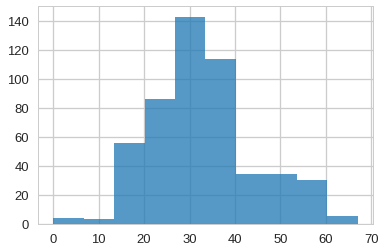

In [5]:
df["totalDocks"].hist(alpha=0.75)

And a histogram of the available bikes across bike stations (real-time):

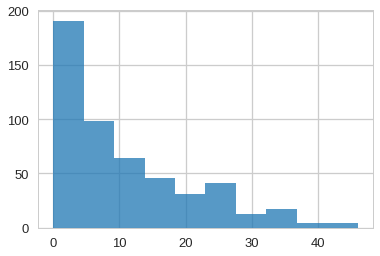

In [6]:
df["availableBikes"].hist(alpha=0.75)

Let's create a variable that shows the percent of capacity at each station.

In [7]:
df["perc_full"] = df['availableBikes']/df['totalDocks']

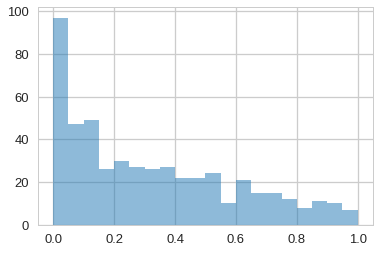

In [8]:
df["perc_full"].hist(alpha=0.5, bins=20)

#### Poor man's mapping

We will now do a small attempt at using a scatterplot, together with the longitude and latitude coordinates to plot things in a map.

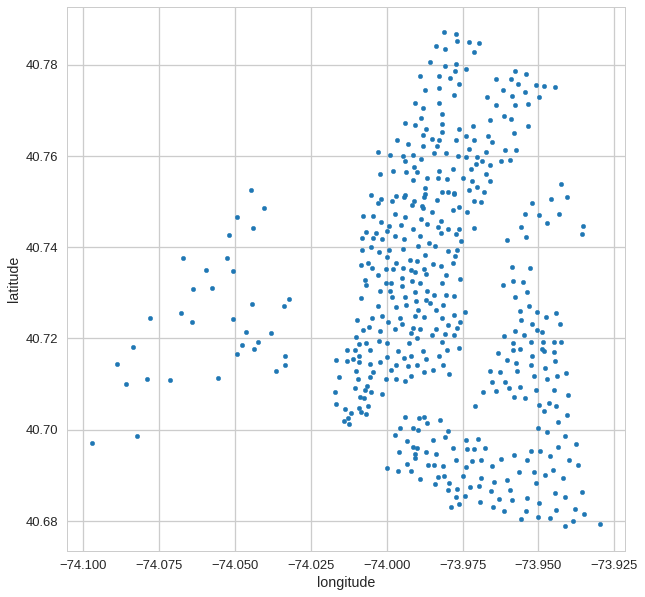

In [9]:
df.plot(
    kind='scatter', 
    x='longitude', 
    y='latitude',
    figsize = (10,10)
)

### Using multiple visual channels for plotting

We used the x and y axes in the plot to show the locations of the stations. 

When we visualize data, we can use multiple visual channels to communicate information. For example, we can use the size of the dot to communicate how full each station is.

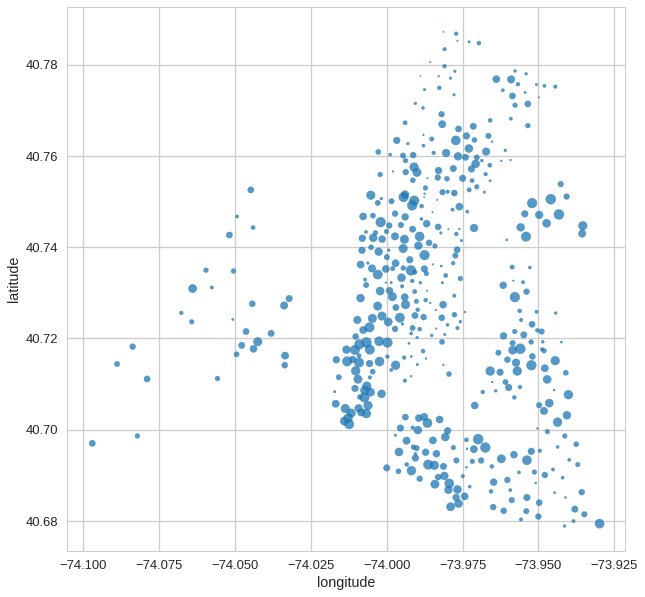

In [10]:
# The s parameter controls the size of the market. We make the size proportional to the perc_full column
df.plot(
    kind='scatter', 
    x='longitude', 
    y='latitude', 
    s = 100*df['perc_full'], alpha=0.75,
    figsize = (10,10)
)

### Using GeoPandas to plot map outlines

We can use GeoPandas to also plot the map underneath the "map" that we created above. For that, we will need to install the geopandas package:

In [11]:
! pip3 install -U geopandas fiona shapely pyproj geopy pysal descartes

     |████████████████████████████████| 1.0MB 20.6MB/s 
     |████████████████████████████████| 15.3MB 304kB/s 
Requirement already up-to-date: shapely in /usr/local/lib/python3.7/dist-packages (1.7.1)
     |████████████████████████████████| 6.5MB 40.9MB/s 
     |████████████████████████████████| 112kB 56.3MB/s 
Requirement already up-to-date: descartes in /usr/local/lib/python3.7/dist-packages (1.1.0)
     |████████████████████████████████| 2.4MB 42.5MB/s 
     |████████████████████████████████| 112kB 44.8MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 92kB 8.4MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 215kB 42.0MB/s 
     |████████████████████████████████| 5.7MB 15.7MB/s 
     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 153kB 

In [12]:
!sudo apt-get install -y libgeos-dev python3-rtree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
libgeos-dev set to manually installed.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 31 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-pkg-resources all 39.0.1-2 [98.8 kB]
Get

In [13]:
import geopandas as gpd

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


To draw the maps, we need the corresponding **shapefile** that describes the shapes of the areas that we want to plot. For our example, we will use the shapefile of the NYC neighborhoods that is available from the NYC Open Data repository.

In [22]:
# Dataset from NYC Open Data: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq
!mkdir data
!rm data/nyc-neighborhoods.geojson
#!curl 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON' -o data/nyc-neighborhoods.geojson
!curl http://people.stern.nyu.edu/nwhite/DealingwithDataSpring2021/data/nyc-neighborhoods.geojson -o data/nyc-neighborhoods.geojson

mkdir: cannot create directory ‘data’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4070k  100 4070k    0     0  4522k      0 --:--:-- --:--:-- --:--:-- 4517k


We use the shapefile that we downloaded (which is in _GeoJSON_ format) and we create a "geo-dataframe". Lets take a peek at the contents.

In [24]:
#!ls data/*#
#!head data/nyc-neighborhoods.geojson
#
df_nyc = gpd.GeoDataFrame.from_file('data/nyc-neighborhoods.geojson')

We can plot the geo information, using our usual syntax.

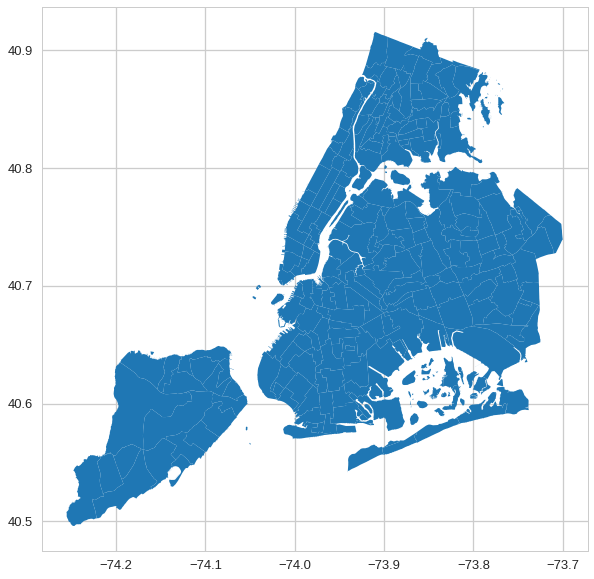

In [27]:
df_nyc.plot(figsize=(10,10))

### Combining plots

We can combine plots by using the `ax` parameter, and pass one plot as parameter to the other. Below, we create the `base` plot, with the neighborhood outlines, and then we pass `base` as the `ax` parameter to the plot that draws the Citibike stations.

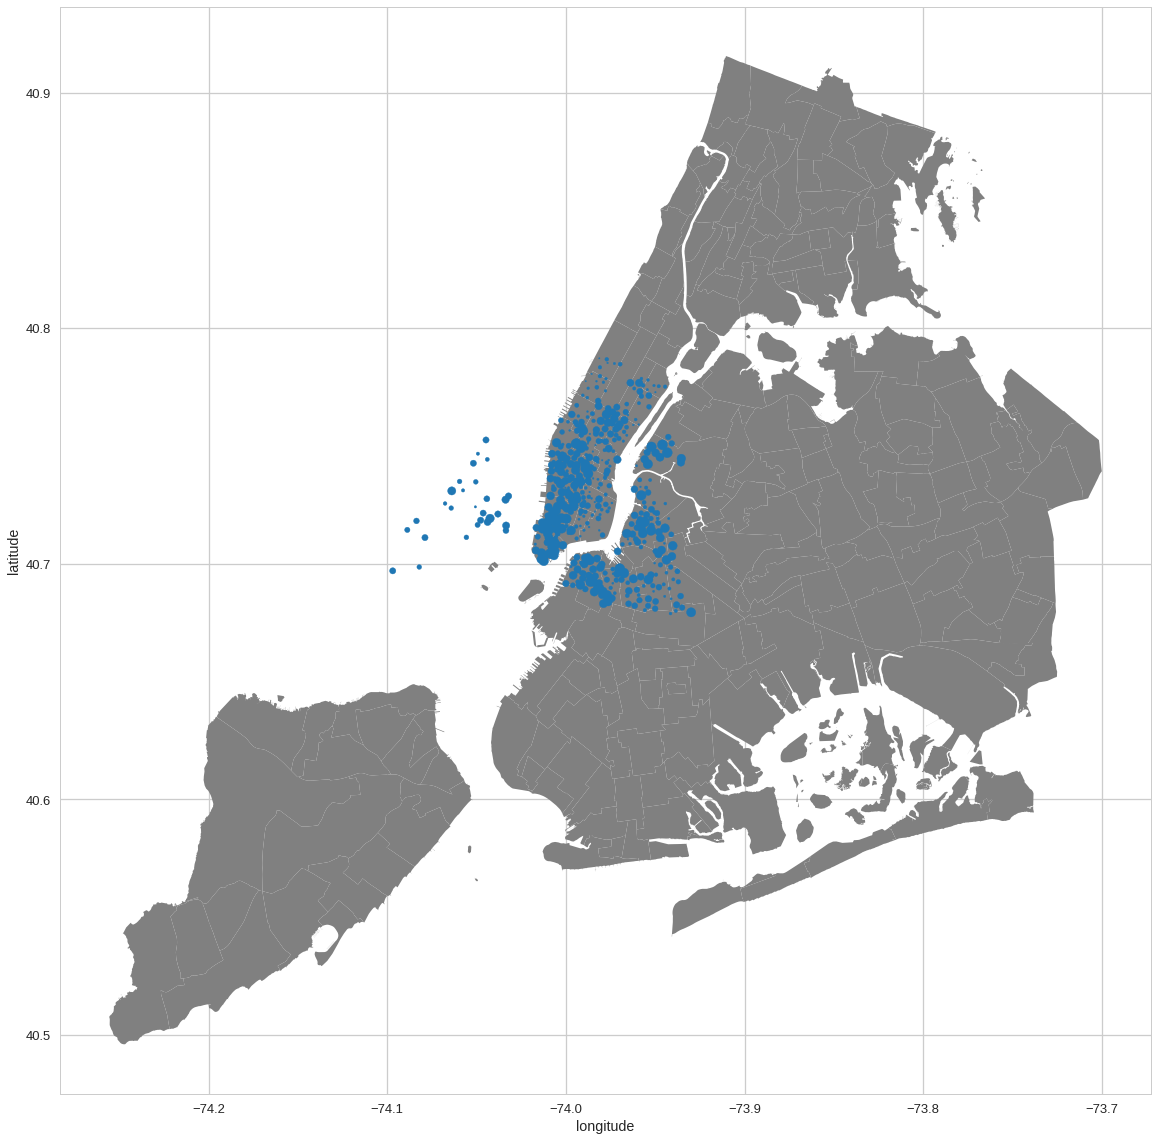

In [30]:
base = df_nyc.plot(linewidth=0.3, color='grey', figsize = (20,20))

df.plot(
    kind='scatter', 
    x='longitude', 
    y='latitude', 
    s = 100*df['perc_full'],
    ax = base
)

### Exercise

* Use the NYC Vehicle Collisions dataset, and plot the accidents with at least one death in the NYC map.

In [ ]:
# your code here

### Beautifying the Plot

* Lets reduce the x- and y- range to focus on the areas for which we have data. We use the `set_xlim` and `set_ylim` for that purpose.
* We will use the `zorder` parameter to define which plot goes to the top, which to the bottom, etc. The element with the lowest zorder goes to the bottom, and the one with the highest zorder on top.

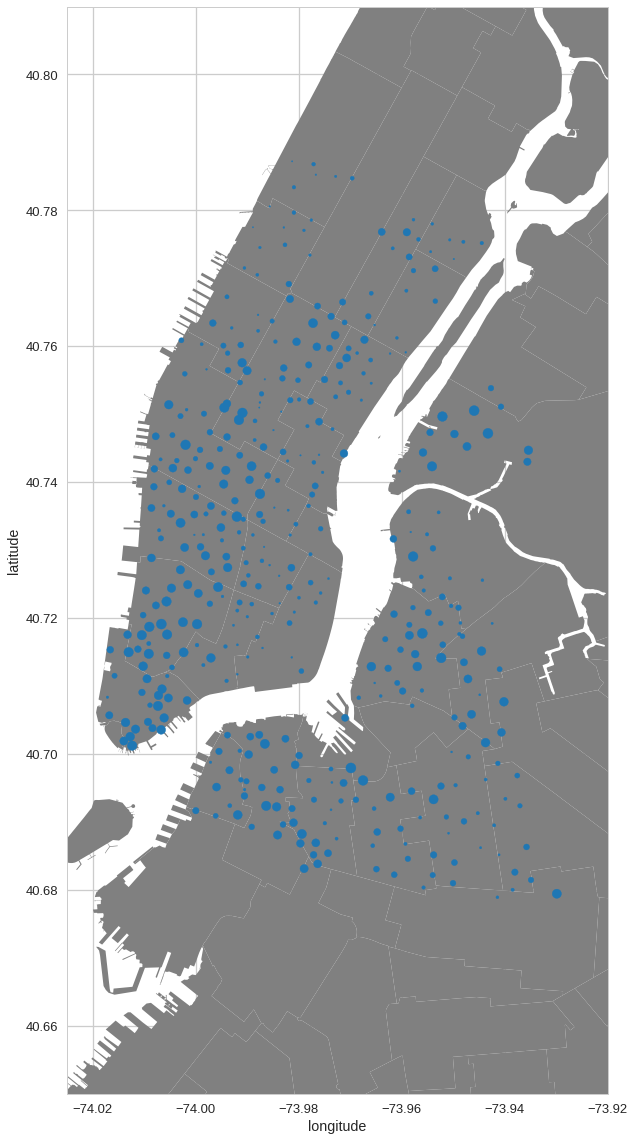

In [38]:
base = df_nyc.plot(linewidth=0.3, color='grey', zorder=1, figsize = (20,20))
base.set_xlim( (-74.025,-73.92)  )
base.set_ylim( (40.65  , 40.81) )
df.plot(
    kind='scatter', 
    x='longitude', 
    y='latitude', 
    s = 100*df['perc_full'],
    ax = base, zorder=2
)

#### Adding more communication channels

Earlier, we used the size of the marker to communicate how full each station is. Now, we will use a different type of a marker, and a different color, to show stations that are out of service.

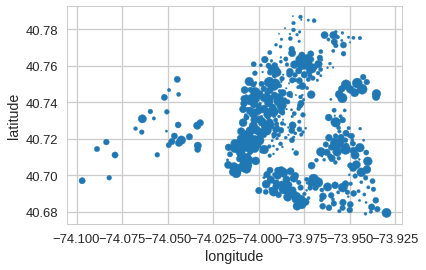

In [42]:
inservice = df[df["statusValue"] == 'In Service']
outofservice = df[df["statusValue"] == 'Not In Service']
inservice.describe()
inservice.plot(kind='scatter',x='longitude',y='latitude',s=100*inservice['perc_full'])

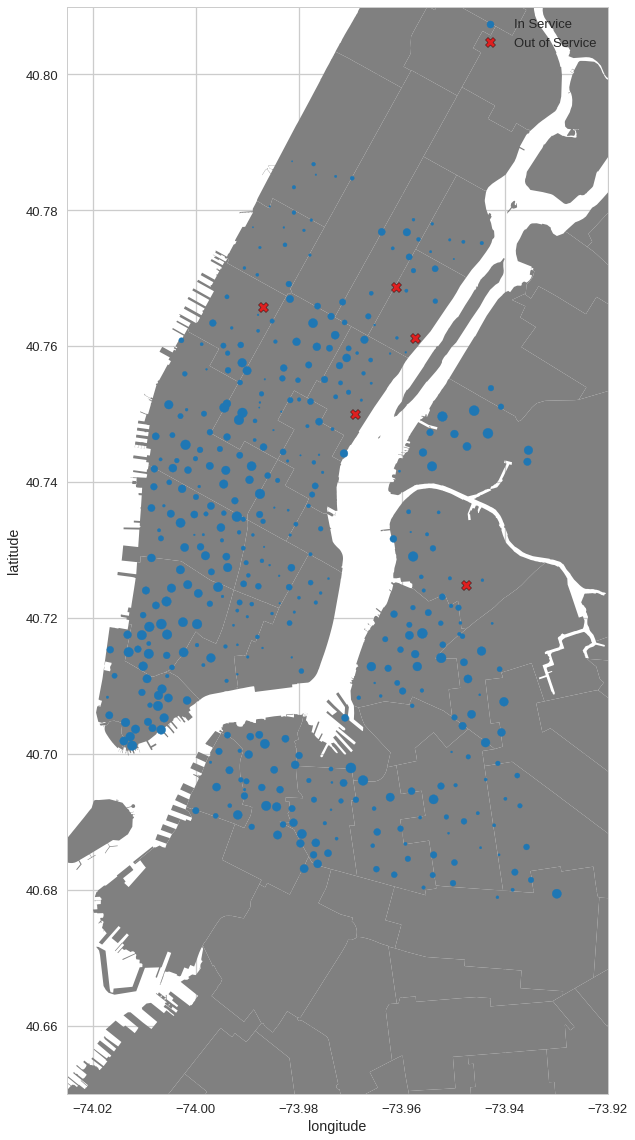

In [43]:
# Plot the map
base = df_nyc.plot(linewidth=0.3, color='grey', zorder=1, figsize = (20,20))
base.set_xlim( (-74.025,-73.92)  )
base.set_ylim( (40.65  , 40.81) )
# Plot the in-service stations, and make the size of each station proportional to its fullness
inservice.plot(
    kind='scatter', 
    x='longitude', 
    y='latitude', 
    s = 100*inservice['perc_full'],
    ax = base, zorder=2, 
    label = 'In Service'
)
# Plots the out-of-service stations with a red x mark
outofservice.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    edgecolor = 'Black', linewidth=0.5,
    color='Red', marker = 'X',
    s = 100, alpha = 0.75, 
    ax = base, 
    label = 'Out of Service', zorder=3)

#### More advanced

The part below tries to add even more communication channels. We change the size of the circle to correspond to the size of the station, and then we use the color transparency to show how full (or empty) the station is. Unfortunately, due to limitations of Pandas, we cannot set directly the transparency of each data point, so we need to go and do the plotting directly using matplotlib functions. In that case, we set the color of each bubble directly.

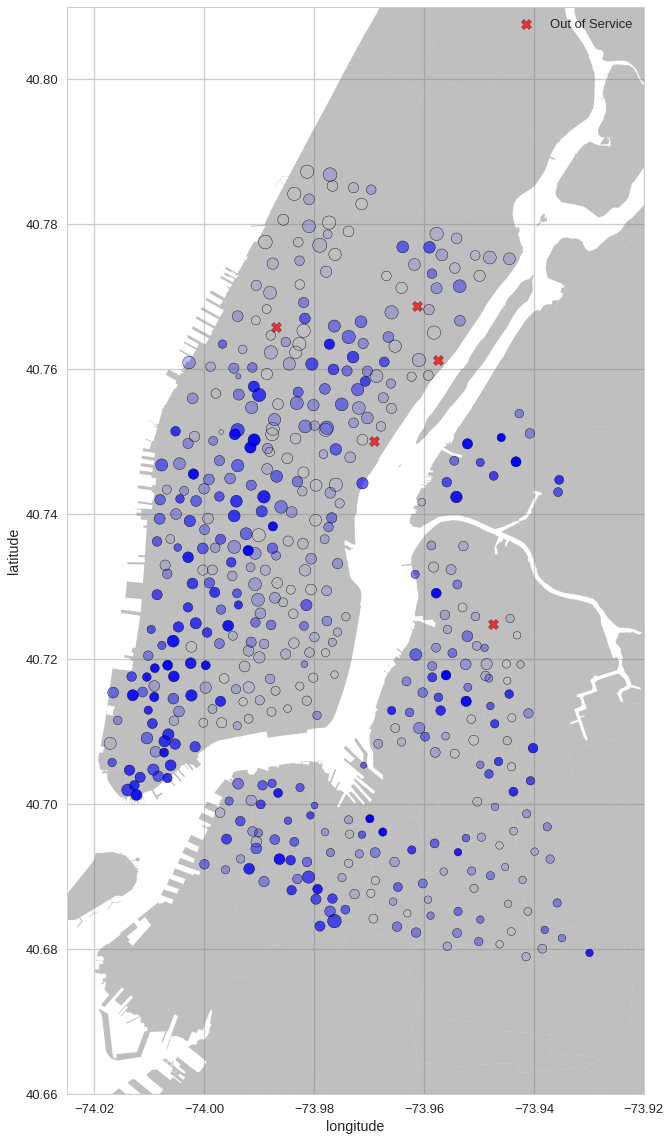

In [46]:
import numpy as np
fig, ax = plt.subplots()
ax.set_aspect('equal')

ax.set_xlim( (-74.025,-73.92)  )
ax.set_ylim( (40.66  , 40.81) )

# And now make the size of each point proportional to the size of available bikes
# using the s option in the plot
inservice = df[df["statusValue"] == 'In Service']
outofservice = df[df["statusValue"] == 'Not In Service']

# alpha is the transparency

df_nyc.plot(linewidth=0.3, color='grey',ax=ax, alpha = 0.5, zorder=1)

# Following http://stackoverflow.com/questions/26738881/setting-scatter-points-transparency-from-data-array-in-matplotlib-plot
# to set alpha in varying degrees
plt.scatter( 
    x=inservice['longitude'],
    y=inservice['latitude'],
    color=np.asarray([(0, 0, 1, a) for a in inservice['perc_full']]), 
    edgecolors='Black', 
    label='In Service',
    s=3*inservice['totalDocks'], 
    zorder=2
)
outofservice.plot(figsize = (20,20),
    kind='scatter',
    ax = ax, 
    x='longitude',
    y='latitude',
    edgecolor = 'Black', color='Red', marker = 'X',
    s = 100, alpha = 0.75,
    label = 'Out of Service', 
    zorder=3
)